In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

c:\users\acro53\python\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
c:\users\acro53\python\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Reading Input Files as Dataframes
companies = pd.read_csv('./Input Files/companies.txt', sep = '\t', encoding = 'palmos')
rounds2 = pd.read_csv('./Input Files/rounds2.csv', sep = ',', encoding = 'palmos')
mapping = pd.read_csv('./Input Files/mapping.csv', sep = ',', encoding = 'palmos')

In [3]:
# A brief look at the companies data
companies.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [4]:
# A brief look at the rounds2 data
rounds2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


In [5]:
# A brief look at the mapping data
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


### Checkpoint 1: Data Cleaning 1

In [6]:
# Number of unique companies in rounds2 dataframe
rounds2.company_permalink = rounds2.company_permalink.str.lower() # Normalising the case of "company_permalink" in rounds2
rounds2['company_permalink'].nunique()

66368

In [7]:
# Number of unique companies in companies dataframe
companies.permalink = companies.permalink.str.lower() # Normalising the case of "permalink" in companies
companies.permalink.nunique()

66368

In [8]:
# Check whether there are any companies in the rounds2 file which are not  present in companies
difference_in_companies = set(rounds2.company_permalink.unique()) - set(companies.permalink.unique()) 
difference_in_companies

set()

In [9]:
# Merging companies and rounds2 dataframe
master_frame = pd.merge(companies, rounds2, left_on = 'permalink', right_on = 'company_permalink', how = 'inner')

In [10]:
# Number of observations present in master_frame
master_frame.shape[0]

114949

### Checkpoint 2: Funding Type Analysis

In [11]:
# Checking percentage of NaN in raised_amount_usd in master_frame
master_frame_without_NaN = master_frame[np.isfinite(master_frame['raised_amount_usd'])]
percent_NaN = (1 - (master_frame_without_NaN.shape[0] / master_frame.shape[0])) * 100
percent_NaN

17.390320924931924

As the percentage of NaNs is high, it seems wiser to drop the rows with NaNs in raised_amount_usd as these can mislead the representation of the data

In [12]:
# Dropping records where "raised_amount_usd" in master_frame is NaN
master_frame = master_frame[np.isfinite(master_frame['raised_amount_usd'])]
# Most representative value of the investment amount of Funding Types
master_frame_sub = master_frame[master_frame.funding_round_type.isin(['venture', 'angel', 'seed', 'private_equity'])].groupby('funding_round_type').raised_amount_usd.mean().reset_index()
pd.set_option('float_format', '{:f}'.format)  # Changing float format
master_frame_sub

,funding_round_type,raised_amount_usd
0,angel,958694.469753
1,private_equity,73308593.029442
2,seed,719817.996907
3,venture,11748949.129490


In [13]:
# Investment Type most suitable for funding between 5-15 Million USD
master_frame_sub[(master_frame_sub['raised_amount_usd'] >= 5000000.0) & (master_frame_sub['raised_amount_usd'] <= 15000000.0)].set_index('funding_round_type')

,raised_amount_usd
funding_round_type,
venture,11748949.129490


### Checkpoint 3: Country Analysis

In [14]:
# Top 9 countries with highest raised amounts in venture type funding
top9 = master_frame[master_frame.funding_round_type == 'venture'].groupby('country_code').raised_amount_usd.sum().sort_values(ascending = False)[0:9]

In [15]:
top9.reset_index()

,country_code,raised_amount_usd
0,USA,422510842796.000000
1,CHN,39835418773.000000
2,GBR,20245627416.000000
3,IND,14391858718.000000
4,CAN,9583332317.000000
5,FRA,7259536732.000000
6,ISR,6907514579.000000
7,DEU,6346959822.000000
8,JPN,3363676611.000000


### Checkpoint 4: Sector Analysis 1

In [16]:
# Reversing the one-hot encoding format of "main sector" in mapping
mapping['main sector'] = (mapping.iloc[:, 1:] == 1).idxmax(1)
# Removing non-relevant values like "Blanks" in "main sector" in mapping
mapping = mapping[~mapping['main sector'].str.contains("Blanks")]
# Subsetting mapping to just "category_list" and "main sector"
mapping = mapping[['category_list', 'main sector']]
# Fetching the first word before "|" for "primary sector"
master_frame['primary sector'] = master_frame.category_list.str.split('|')
master_frame['primary sector'] = master_frame.category_list.str.split('|', n=1, expand = True)
master_frame = pd.merge(master_frame, mapping, left_on = 'primary sector', right_on = 'category_list' ,how = 'inner')
master_frame.head()

,permalink,name,homepage_url,category_list_x,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary sector,category_list_y,main sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.000000,Media,Media,Entertainment
1,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.000000,Media,Media,Entertainment
2,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.000000,Media,Media,Entertainment
3,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,NaN,26-03-2014,18000000.000000,Media,Media,Entertainment
4,/organization/a-dance-for-me,A Dance for Me,http://www.adanceforme.com/,Media|News|Photo Sharing|Video,operating,USA,MT,Missoula,Missoula,31-07-2011,/organization/a-dance-for-me,/funding-round/9ab9dbd17bf010c79d8415b2c22be6fa,equity_crowdfunding,NaN,26-03-2014,1090000.000000,Media,Media,Entertainment


### Checkpoint 5: Sector Analysis 2

In [17]:
# The most heavily invested main sectors in each of the three countries (USA, Great Britain, India) for funding type 'Venture' and investments range of 5-15 Million USD
USA_df = master_frame[(master_frame['country_code'] == 'USA') & (master_frame['funding_round_type'] == 'venture') & ((master_frame['raised_amount_usd'] >= 5000000.0) & (master_frame['raised_amount_usd'] <= 15000000.0))]
GBR_df = master_frame[(master_frame['country_code'] == 'GBR') & (master_frame['funding_round_type'] == 'venture') & ((master_frame['raised_amount_usd'] >= 5000000.0) & (master_frame['raised_amount_usd'] <= 15000000.0))]
IND_df = master_frame[(master_frame['country_code'] == 'IND') & (master_frame['funding_round_type'] == 'venture') & ((master_frame['raised_amount_usd'] >= 5000000.0) & (master_frame['raised_amount_usd'] <= 15000000.0))]

In [18]:
# USA (Country 1 Statistics)
print ("Total number of investments (count): " , USA_df.funding_round_permalink.count())
print ("\nTotal amount of investment (in USD): ", USA_df.raised_amount_usd.sum())
print ("\nTop 3 sectors (Number of investments wise): \n", USA_df.groupby('main sector').funding_round_permalink.count().sort_values(ascending = False)[0:4])

Total number of investments (count):  11149

Total amount of investment (in USD):  99661524549.0

Top 3 sectors (Number of investments wise): 
 main sector
Others                                     2923
Cleantech / Semiconductors                 2297
Social, Finance, Analytics, Advertising    1912
News, Search and Messaging                 1563
Name: funding_round_permalink, dtype: int64


From above, we can find that "Cleantech / Semiconductors", "Social, Finance, Analytics, Advertising" and "News, Search and Messaging" sectors contribute most in the USA. Let's find the top companies contributing to the fundings in these sectors.

Here, "Others" does not represent an individual sector but a set of different sectors, thus, not taken into consideration.

In [19]:
# Top company contributing to highest funding in "Cleantech / Semiconductors" sector in the USA
USA_df[USA_df['main sector'] == 'Cleantech / Semiconductors'].groupby('name').raised_amount_usd.sum().sort_values(ascending = False)[0:1]

name
Biodesix   75300000.000000
Name: raised_amount_usd, dtype: float64

In [20]:
# Top company contributing to highest funding in "Social, Finance, Analytics, Advertising" sector in the USA
USA_df[USA_df['main sector'] == 'Social, Finance, Analytics, Advertising'].groupby('name').raised_amount_usd.sum().sort_values(ascending = False)[0:1]

name
Intacct   61800000.000000
Name: raised_amount_usd, dtype: float64

In [21]:
# Great Britain (Country 2 Statistics)
print ("Total number of investments (count): " , GBR_df.funding_round_permalink.count())
print ("\nTotal amount of investment (in USD): ", GBR_df.raised_amount_usd.sum())
print ("\nTop 3 sectors (Number of investments wise): \n", GBR_df.groupby('main sector').funding_round_permalink.count().sort_values(ascending = False)[0:4])

Total number of investments (count):  577

Total amount of investment (in USD):  5028704358.0

Top 3 sectors (Number of investments wise): 
 main sector
Others                                     143
Cleantech / Semiconductors                 127
Social, Finance, Analytics, Advertising     98
News, Search and Messaging                  73
Name: funding_round_permalink, dtype: int64


From above, we can find that "Cleantech / Semiconductors", "Social, Finance, Analytics, Advertising" and "News, Search and Messaging" sectors contribute most in Great Britain. Let's find the top companies contributing to the fundings in these sectors.

In [22]:
# Top company contributing to highest funding in "Cleantech / Semiconductors" sector in Great Britain
GBR_df[GBR_df['main sector'] == 'Cleantech / Semiconductors'].groupby('name').raised_amount_usd.sum().sort_values(ascending = False)[0:1]

name
EUSA Pharma   35600000.000000
Name: raised_amount_usd, dtype: float64

In [23]:
# Top company contributing to highest funding in "Social, Finance, Analytics, Advertising" sector in Great Britain
GBR_df[GBR_df['main sector'] == 'Social, Finance, Analytics, Advertising'].groupby('name').raised_amount_usd.sum().sort_values(ascending = False)[0:1]

name
Celltick Technologies   37500000.000000
Name: raised_amount_usd, dtype: float64

In [24]:
# India (Country 3 Statistics)
print ("Total number of investments (count): " , IND_df.funding_round_permalink.count())
print ("\nTotal amount of investment (in USD): ", IND_df.raised_amount_usd.sum())
print ("\nTop 3 sectors (Number of investments wise): \n", IND_df.groupby('main sector').funding_round_permalink.count().sort_values(ascending = False)[0:4])

Total number of investments (count):  299

Total amount of investment (in USD):  2683537552.0

Top 3 sectors (Number of investments wise): 
 main sector
Others                                     109
News, Search and Messaging                  52
Entertainment                               33
Social, Finance, Analytics, Advertising     32
Name: funding_round_permalink, dtype: int64


From above, we can find that "News, Search and Messaging", "Entertainment" and "Social, Finance, Analytics, Advertising" sectors contribute most in India. Let's find the top companies contributing to the fundings in these sectors.

In [25]:
# Top company contributing to highest funding in "News, Search and Messaging" sector in India
IND_df[IND_df['main sector'] == 'News, Search and Messaging'].groupby('name').raised_amount_usd.sum().sort_values(ascending = False)[0:1]

name
GupShup   33000000.000000
Name: raised_amount_usd, dtype: float64

In [26]:
# Top company contributing to highest funding in "Entertainment" sector in India
IND_df[IND_df['main sector'] == 'Entertainment'].groupby('name').raised_amount_usd.sum().sort_values(ascending = False)[0:1]

name
Yebhi   21000000.000000
Name: raised_amount_usd, dtype: float64

### Checkpoint 6: Plots

Text(0.5,0,'Average Amount raised in USD (e^11)')

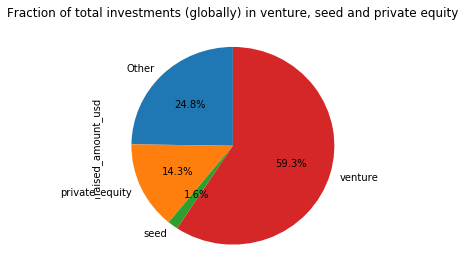

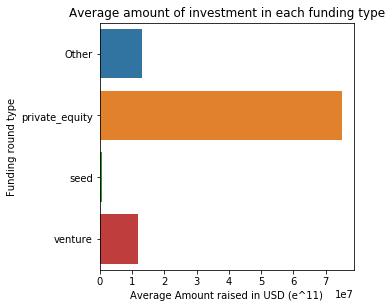

In [30]:
# Plot showing the fraction of total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type
master_frame.loc[~master_frame.funding_round_type.isin(['venture', 'seed', 'private_equity']), 'funding_round_type'] = "Other"
sub_df1 = master_frame[master_frame.funding_round_type.isin(['venture', 'seed', 'private_equity', 'Other'])]
sub_df1 = sub_df1.groupby('funding_round_type').raised_amount_usd.sum().reset_index()
sub_df2 = master_frame[master_frame.funding_round_type.isin(['venture', 'seed', 'private_equity', 'Other'])]
sub_df2 = sub_df2.groupby('funding_round_type').raised_amount_usd.mean().reset_index()
#Plot 1
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
sub_df1.plot(kind='pie', y = 'raised_amount_usd', ax=ax1, autopct='%1.1f%%',startangle=90, shadow=False, labels= sub_df1['funding_round_type'], legend = False, fontsize=10)
plt.title("Fraction of total investments (globally) in venture, seed and private equity")
#Plot 2
plt.figure(figsize=(10,10))
ax2 = plt.subplot(2,2,2)
sns.barplot(y = 'funding_round_type', x = 'raised_amount_usd', ax= ax2, data = sub_df2)
plt.title("Average amount of investment in each funding type")
plt.ylabel("Funding round type")
plt.xlabel("Average Amount raised in USD (e^11)")

Text(0,0.5,'Total amount invested in USD (in e^11)')

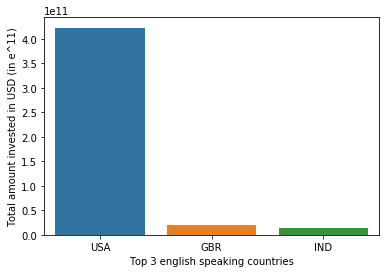

In [31]:
# Plot showing venture funding across top 3 english speaking countries
top9 = top9.reset_index()
top3 = top9[top9.country_code.isin(['USA', 'GBR', 'IND'])]
sns.barplot(x = 'country_code', y = 'raised_amount_usd', data = top3)
plt.xlabel("Top 3 english speaking countries")
plt.ylabel("Total amount invested in USD (in e^11)")

Text(0.5,21.7063,'Top 3 english speaking countries')

<Figure size 720x720 with 0 Axes>

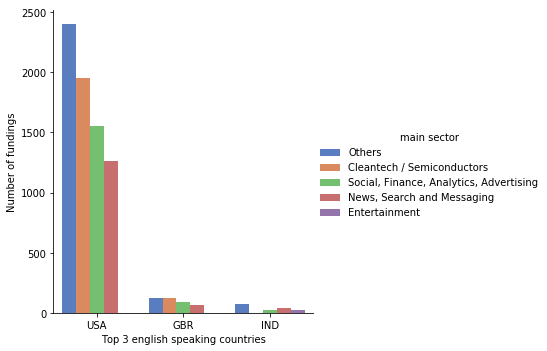

In [33]:
# Plot showing venture funding in top 3 sectors of the top 3 english speaking countries
subset = master_frame[(master_frame['country_code'].isin(['USA', 'GBR', 'IND'])) & (master_frame['funding_round_type'] == 'venture') & ((master_frame['raised_amount_usd'] > 5000000.0) & (master_frame['raised_amount_usd'] < 15000000.0))]
subset = subset.groupby(['country_code', 'main sector']).funding_round_permalink.count().sort_values(ascending = False).groupby('country_code').head(4).reset_index()
plt.figure(figsize=(10,10))
sns.catplot(x = 'country_code', y = 'funding_round_permalink', hue = 'main sector', data = subset,height=5, kind="bar", palette="muted")
plt.ylabel('Number of fundings')
plt.xlabel('Top 3 english speaking countries')